In [144]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [145]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'

SMOOTH = False

SEED = 1910



## 1. ETL

In [146]:
from src import spectrumloader as spl
from src import get_torch_loader as tlg
# from src.modeltorch_template import NeuralNet,RamConv1d,RamLSTM,RamConv1d_bnmx,IntANN,IntRamLSTM,RamConv1d_mx
from src import trainResult_show as mtp

In [147]:
standard,data_all = spl.read_file('dataset/')

In [148]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [149]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [150]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [151]:
X_train_VR = spl.fluoresence_removal(X_trainall)
if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)

In [152]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

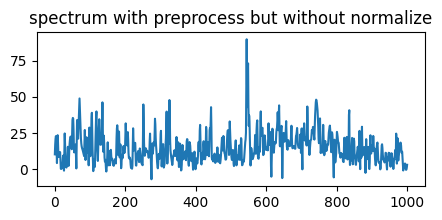

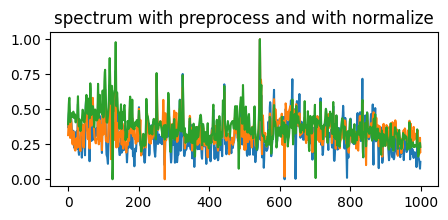

In [153]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

## 5. apply data to pytorch

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [155]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))



In [156]:
train_size = 12
val_size = 4
batch_size=12
valbatch_size=4
train_loader_all,val_loader_all = tlg.shuffleloadertorch(ds_earloop,ds_inarm,ds_thumbnail,ds_vain,SEED,train_size,val_size,batch_size,valbatch_size)

## 6. modeling


In [157]:
class RamGRU(nn.Module):
    def __init__(self, input_size = 1000, hidden_size=50, out_size=2):
        super().__init__()
        #with dropout
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_size, out_size)
        
    def forward(self, seq):
        out, _ = self.gru(seq)
        out = out[:, -1, :] #(B, Hout)

        out = self.linear(out)
        return out

model = RamGRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model


RamGRU(
  (gru): GRU(1000, 50, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [158]:
# EXAM PLE model_RNN_for_earloop = RamLSTM().to(device)

model_RNN_for_earloop = RamGRU().to(device)
model_RNN_for_inarm = RamGRU().to(device)
model_RNN_for_thumbnail = RamGRU().to(device)
model_RNN_for_vain = RamGRU().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [159]:
simRNN_models[0]

RamGRU(
  (gru): GRU(1000, 50, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [160]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 6.55 - Acc: 0.00     ++++++Validation++++++  Loss: 6.20 - Acc: 0.00 
 END OF MODEL for ear lobe with val acc = 0.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 3.61 - Acc: 25.00    ++++++Validation++++++  Loss: 2.28 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 0.26 - Acc: 100.00     ++++++Validation++++++  Loss: 0.31 - Acc: 100.00 
 END OF MODEL for thumb nail with val acc = 100.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0004    ++++++Validation++++++  Loss: 7.24 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


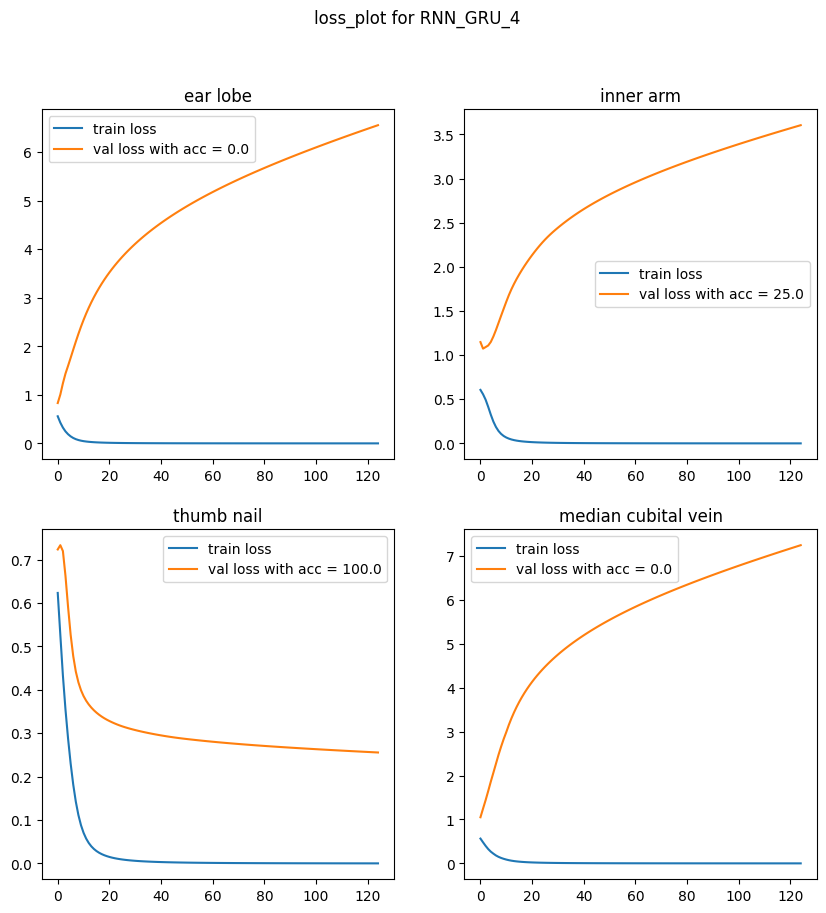

In [161]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'RNN_GRU_4')

I did cross Validation 5 times and the result is as follow :
First Time with the seed 25811243 : 25,75,50,25
Second Time with the seed 34806794 : 75,50,25,25
Third Time with the seed  2022 : 25,50,75,75
Fourth Time with the seed  1910 : 0,25,100,0
Fifth Time with the seed  222 : 25,75, 75,50 

I think 4 out of 5 results are good and balanced enough to say that the model is not overfitting. 


In [162]:
#write complex and advanced GRU model from scratch and test it on the data set and compare it with the simple GRU model above

class RamGRU(nn.Module):
    def __init__(self, input_size = 1000, hidden_size=50, out_size=2):
        super().__init__()
        #with dropout
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.gru_1 = nn.GRU(hidden_size, hidden_size , batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_size, out_size)
        
    def forward(self, seq):
        out, _ = self.gru(seq)
        out, _ = self.gru_1(out)
        out = self.linear(out[:, -1, :])
        return out

        #out = self.linear(out)
        #return out[:,-1,:]


In [163]:
model = RamGRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model

RamGRU(
  (gru): GRU(1000, 50, batch_first=True, dropout=0.2)
  (gru_1): GRU(50, 50, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [164]:
# EXAM PLE model_RNN_for_earloop = RamLSTM().to(device)

model_RNN_for_earloop = RamGRU().to(device)
model_RNN_for_inarm = RamGRU().to(device)
model_RNN_for_thumbnail = RamGRU().to(device)
model_RNN_for_vain = RamGRU().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [165]:
simRNN_models[0]

RamGRU(
  (gru): GRU(1000, 50, batch_first=True, dropout=0.2)
  (gru_1): GRU(50, 50, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [166]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader): 
            model.train() 
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 7.39 - Acc: 0.00      ++++++Validation++++++  Loss: 5.12 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 0.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 4.15 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 0.13 - Acc: 100.00 
 END OF MODEL for thumb nail with val acc = 100.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0001    ++++++Validation++++++  Loss: 9.23 - Acc: 0.00    ++++++Validation++++++  Loss: 5.68 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


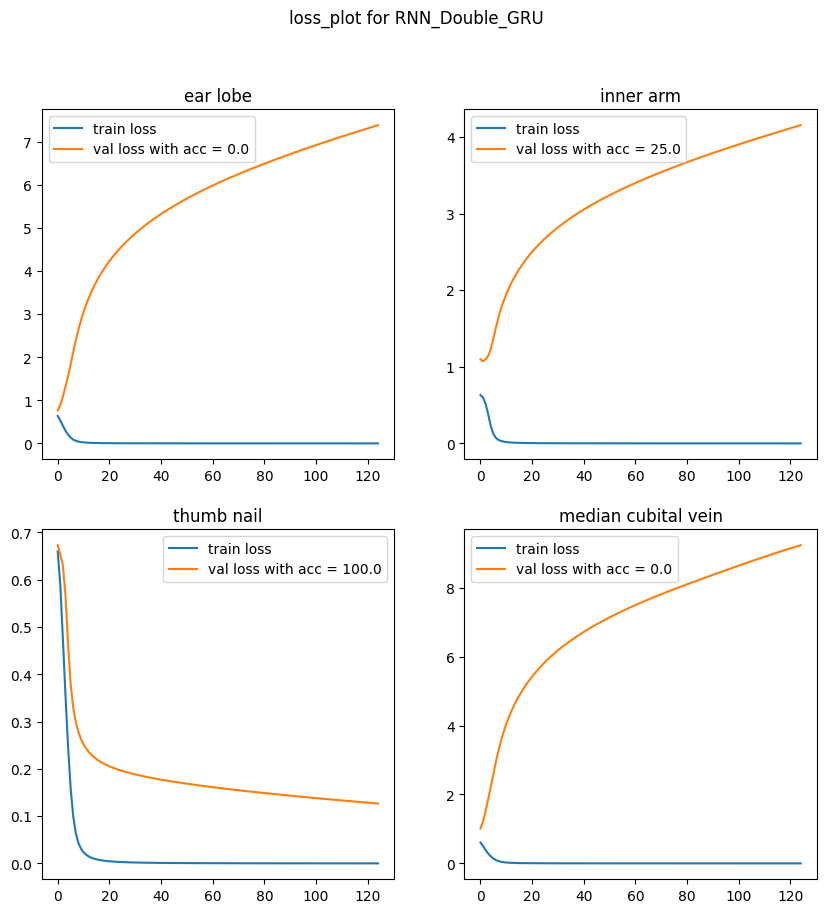

In [167]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'RNN_Double_GRU')

In [168]:
#redesign the model so that the validation loss is not so high and it goes down with the training loss and the accuracy is high enough to be useful (at least 70% for each location) #Done

class RamGRU(nn.Module):
    def __init__(self, hidden_size=128, out_size=2):
        super(RamGRU, self).__init__()
        self.gru = nn.GRU(1000, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.hidden_size = hidden_size
        self.out_size = out_size

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.gru(x, hidden)
        out = self.linear(out[:, -1, :])
        out = self.softmax(out)
        return out
    
    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

model_RNN_for_earloop = RamGRU().to(device)
model_RNN_for_inarm = RamGRU().to(device)
model_RNN_for_thumbnail = RamGRU().to(device)
model_RNN_for_vain = RamGRU().to(device)

criterion_for_earloop = nn.CrossEntropyLoss()
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)

criterion_for_inarm = nn.CrossEntropyLoss()
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)

criterion_for_thumbnail = nn.CrossEntropyLoss()
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []



In [169]:
simRNN_models[0]

RamGRU(
  (gru): GRU(1000, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [170]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.3133    ++++++Validation++++++  Loss: 1.16 - Acc: 25.00     ++++++Validation++++++  Loss: 1.15 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.3133    ++++++Validation++++++  Loss: 0.97 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.3133    ++++++Validation++++++  Loss: 0.45 - Acc: 75.00      ++++++Validation++++++  Loss: 0.45 - Acc: 75.00 
 END OF MODEL for thumb nail with val acc = 75.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.3133    ++++++Validation++++++  Loss: 1.31 - Acc: 0.00     ++++++Validation++++++  Loss: 1.31 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


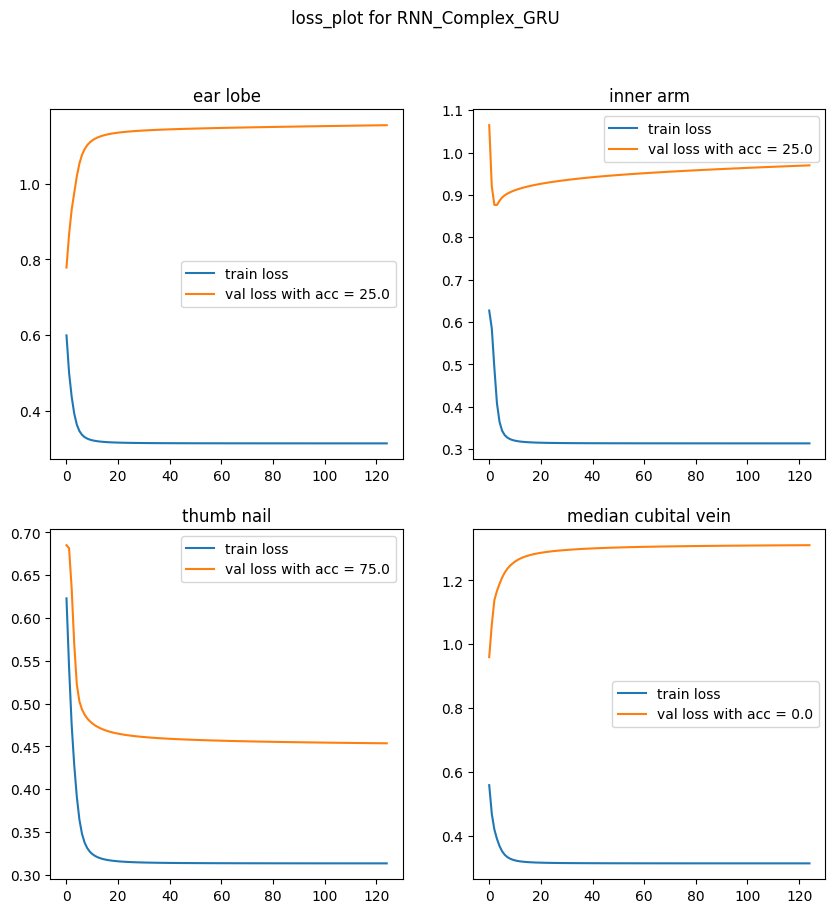

In [171]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'RNN_Complex_GRU')